In [1]:
!pip install --quiet pandas networkx gensim scikit-learn plotly matplotlib scipy tqdm umap-learn kaleido

In [3]:
import os, random, json
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
from scipy import sparse
import umap

# CONFIG
NODES_CSV = "data/nodes.csv"
EDGES_CSV = "data/edges.csv"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Improved Node2Vec parameters
NUM_WALKS = 20
WALK_LENGTH = 60
EMB_DIM = 128
WINDOW = 2
EPOCHS = 10

In [5]:
def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, dtype=str)

nodes_df = safe_read_csv(NODES_CSV)
edges_df = safe_read_csv(EDGES_CSV)

# Remove unwanted columns
nodes_df = nodes_df.loc[:, ~nodes_df.columns.str.contains("^Unnamed")].copy()
edges_df = edges_df.loc[:, ~edges_df.columns.str.contains("^Unnamed")].copy()

print(nodes_df.head())
print(edges_df.head())

    nodeId labels                 subject  \
0    31336  Paper         Neural_Networks   
1  1061127  Paper           Rule_Learning   
2  1106406  Paper  Reinforcement_Learning   
3    13195  Paper  Reinforcement_Learning   
4    37879  Paper   Probabilistic_Methods   

                                            features  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
  sourceNodeId targetNodeId relationshipType
0           35         1033            CITES
1           35       103482            CITES
2           35       103515            CITES
3           35      1050679            CITES
4           35      1103960            CITES


In [7]:
import ast

def parse_feat(x):
    try:
        return np.array(ast.literal_eval(x), dtype=float)
    except:
        return np.zeros(10)

nodes_df["features_parsed"] = nodes_df["features"].apply(parse_feat)

print("Feature length:", len(nodes_df["features_parsed"].iloc[0]))

Feature length: 1433


In [9]:
G = nx.DiGraph()

node_id_col = [c for c in nodes_df.columns if c.lower() in ("nodeid","node_id","id")][0]
src_col = [c for c in edges_df.columns if "source" in c.lower()][0]
tgt_col = [c for c in edges_df.columns if "target" in c.lower()][0]

for _, row in nodes_df.iterrows():
    nid = str(row[node_id_col])
    G.add_node(nid,
               subject=row.get("subject"),
               labels=row.get("labels"),
               features=row["features_parsed"])

for _, row in edges_df.iterrows():
    G.add_edge(str(row[src_col]), str(row[tgt_col]))

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 2708
Edges: 10556


In [71]:
# =======================
# INTRODUCTORY GRAPH SUMMARY
# =======================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("\n================ GRAPH STRUCTURE SUMMARY ================\n")

# --- Basic counts ---
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

print(f"Total Nodes:  {num_nodes}")
print(f"Total Edges:  {num_edges}")
print(f"Graph Type:   {'Directed' if is_directed else 'Undirected'}")

# --- Degree statistics ---
degrees = dict(G.degree())
degree_values = np.array(list(degrees.values()))

deg_stats = {
    "min_degree": degree_values.min(),
    "max_degree": degree_values.max(),
    "mean_degree": degree_values.mean(),
    "median_degree": np.median(degree_values),
    "std_degree": degree_values.std()
}

deg_stats_df = pd.DataFrame([deg_stats])
print("\n=== Degree Statistics ===")
display(deg_stats_df)



================ GRAPH STRUCTURE SUMMARY ================

Total Nodes:  2708
Total Edges:  10556
Graph Type:   Directed

=== Degree Statistics ===


,min_degree,max_degree,mean_degree,median_degree,std_degree
0,2,336,7.79616,6.0,10.455637


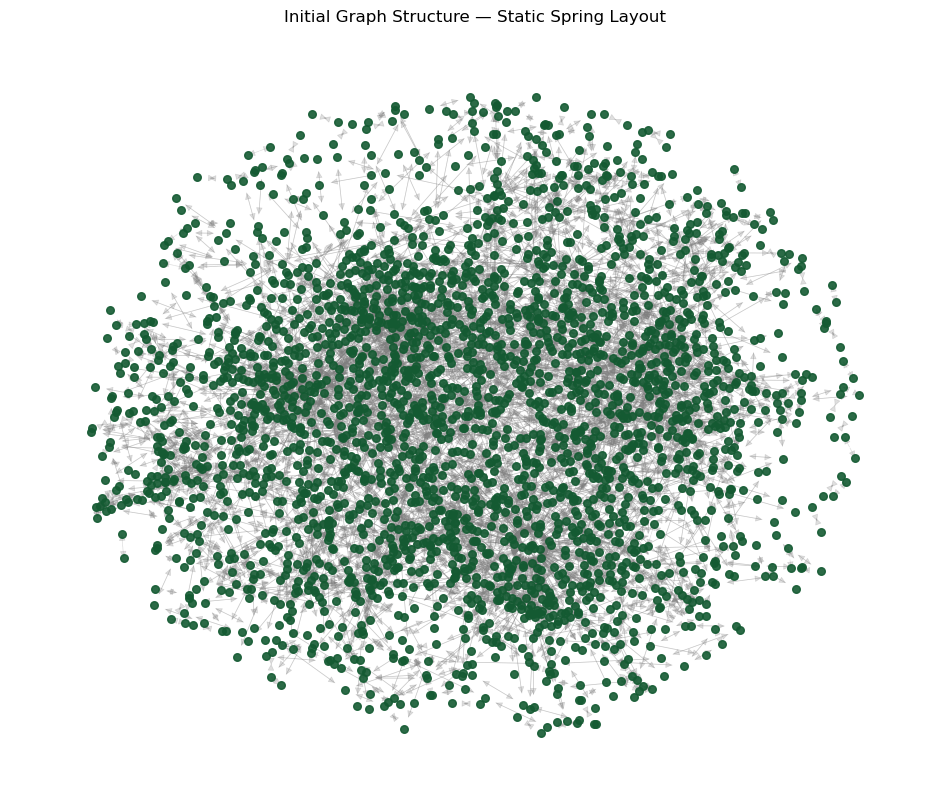

Saved initial static graph visualization to: outputs/initial_graph_structure.png


In [77]:
# ================================
# Initial Graph View 
# Static Spring Layout 
# ================================

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 10))

# Use spring layout (force-directed)
pos_initial = nx.spring_layout(G.to_undirected(), seed=42, k=0.15, iterations=100)

# 1. Draw edges (light gray)
nx.draw_networkx_edges(
    G,
    pos_initial,
    alpha=0.25,
    width=0.5,
    edge_color="gray"
)

# 2. Draw nodes (ALL SAME COLOR)
nx.draw_networkx_nodes(
    G,
    pos_initial,
    node_color="#145A32",  # single color
    node_size=30,
    alpha=0.9
)

plt.title("Initial Graph Structure — Static Spring Layout")
plt.axis("off")

# Save high-resolution PNG
static_intro_path = f"{OUT_DIR}/initial_graph_structure.png"
plt.savefig(static_intro_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved initial static graph visualization to:", static_intro_path)


In [11]:
node_list = list(G.nodes())

A_array = nx.to_scipy_sparse_array(G, nodelist=node_list, dtype=np.float32)
A = sparse.csr_matrix(A_array)

sparse.save_npz(f"{OUT_DIR}/graph_A.npz", A)
with open(f"{OUT_DIR}/graph_nodes.json","w") as f:
    json.dump(node_list, f)

print("Saved adjacency and node list.")

Saved adjacency and node list.


In [13]:
def random_walk(G, start, length):
    walk = [start]
    for _ in range(length - 1):
        nbrs = list(G.successors(walk[-1])) + list(G.predecessors(walk[-1]))
        if not nbrs: break
        walk.append(random.choice(nbrs))
    return walk

walks = []
for _ in range(NUM_WALKS):
    random.shuffle(node_list)
    for n in tqdm(node_list, desc="walks"):
        walks.append(random_walk(G, n, WALK_LENGTH))

model = Word2Vec(
    walks,
    vector_size=EMB_DIM,
    window=WINDOW,
    sg=1,
    workers=2,
    epochs=EPOCHS,
    min_count=0
)

emb_mat = np.vstack([model.wv.get_vector(str(n)) for n in node_list])
np.save(f"{OUT_DIR}/emb_matrix.npy", emb_mat)

print("Node2Vec embedding shape:", emb_mat.shape)

walks: 100%|█████████████████████████████| 2708/2708 [00:00<00:00, 12110.09it/s]


Node2Vec embedding shape: (2708, 128)


In [15]:
feature_mat = np.vstack([G.nodes[n]["features"] for n in node_list])

# Match dimensions (pad if needed)
max_len = max(len(x) for x in feature_mat)
feature_mat = np.array([np.pad(x, (0, max_len-len(x))) for x in feature_mat])

print("Feature matrix:", feature_mat.shape)

# === FINAL EMBEDDING ===
final_emb = np.hstack([emb_mat, feature_mat])
print("Final fused embedding:", final_emb.shape)

Feature matrix: (2708, 1433)
Final fused embedding: (2708, 1561)


In [17]:
umap_emb = umap.UMAP(
    n_components=20,
    min_dist=0.1,
    n_neighbors=30,
    random_state=42
).fit_transform(final_emb)

print("UMAP embedding shape:", umap_emb.shape)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (2708, 20)


In [65]:
possible_k = [4,5,6,7,8,9,10,11,12]

best_k = None
best_score = -1
best_labels = None

for k in possible_k:
    km = KMeans(n_clusters=k, random_state=42).fit(umap_emb)
    sil = silhouette_score(umap_emb, km.labels_)
    print(f"k={k} => silhouette={sil:.4f}")
    if sil > best_score:
        best_score = sil
        best_k = k
        best_labels = km.labels_

print("\nBest k:", best_k, " with silhouette=", best_score)
labels = best_labels

k=4 => silhouette=0.2742
k=5 => silhouette=0.3120
k=6 => silhouette=0.2967
k=7 => silhouette=0.3152
k=8 => silhouette=0.3568
k=9 => silhouette=0.3507
k=10 => silhouette=0.3383
k=11 => silhouette=0.3434
k=12 => silhouette=0.3125

Best k: 8  with silhouette= 0.3567685


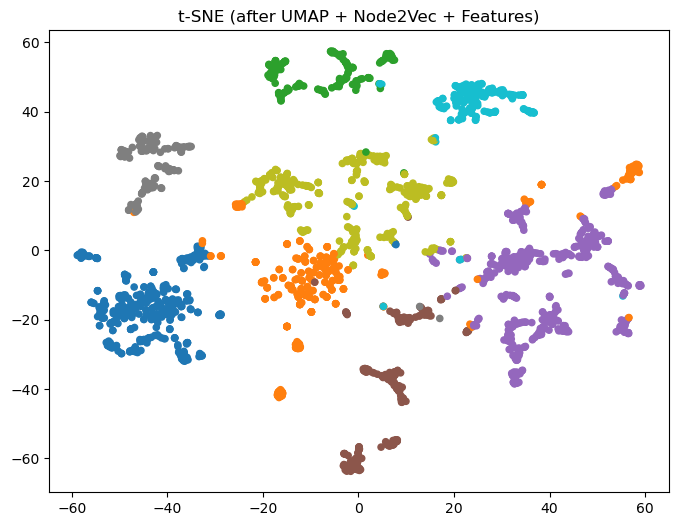

In [21]:
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(umap_emb)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=labels, cmap="tab10", s=20)
plt.title("t-SNE (after UMAP + Node2Vec + Features)")
plt.savefig(f"{OUT_DIR}/tsne.png", dpi=200)
plt.show()

In [23]:
print("=== Clustering Metrics ===")

sil = silhouette_score(umap_emb, labels)
ch = calinski_harabasz_score(umap_emb, labels)
db = davies_bouldin_score(umap_emb, labels)

print("Silhouette:", sil)
print("Calinski–Harabasz:", ch)
print("Davies–Bouldin:", db)

# Optional: supervised metrics
true_labels_available = False
if "subject" in nodes_df.columns:
    gt_col = "subject"
    true_labels_available = True
elif "labels" in nodes_df.columns:
    gt_col = "labels"
    true_labels_available = True

if true_labels_available:
    df_indexed = nodes_df.set_index(node_id_col)
    gt = np.array([df_indexed.loc[n, gt_col] if n in df_indexed.index else "Unknown"
                   for n in node_list])
    mask = (gt != "Unknown")

    nmi = normalized_mutual_info_score(gt[mask], labels[mask])
    ari = adjusted_rand_score(gt[mask], labels[mask])

    print("NMI:", nmi)
    print("ARI:", ari)
else:
    print("No true labels for NMI/ARI.")

=== Clustering Metrics ===
Silhouette: 0.3567685
Calinski–Harabasz: 844.2693835565942
Davies–Bouldin: 1.260298029817654
NMI: 0.4710091291853472
ARI: 0.3871089782455193


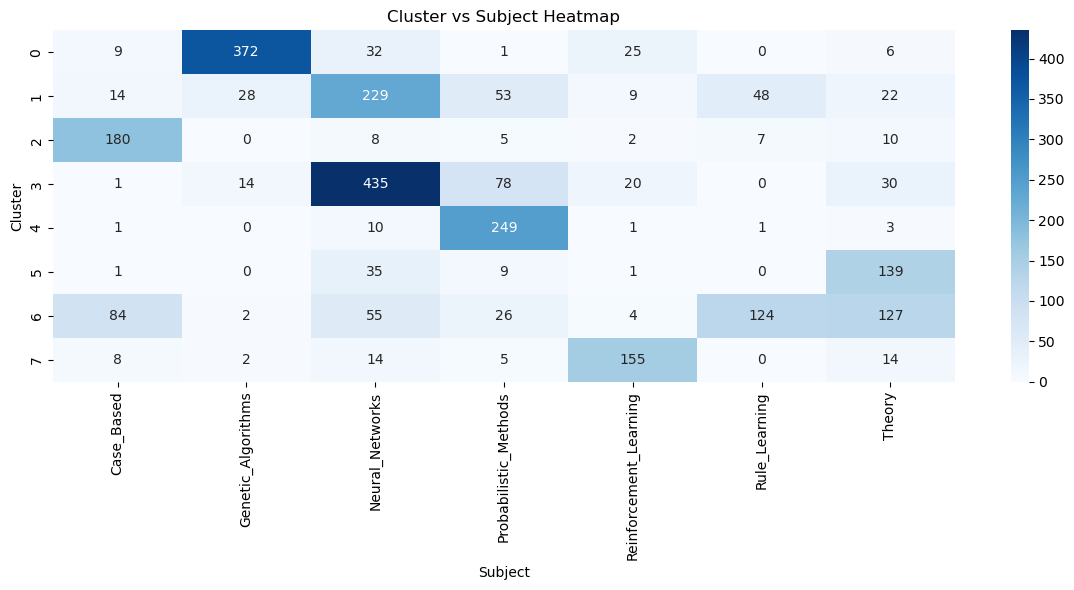

In [25]:
# Cell V1 — Cluster vs Subject heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_indexed = nodes_df.set_index(node_id_col)

subjects = []
for n in node_list:
    if n in df_indexed.index:
        subjects.append(df_indexed.loc[n, "subject"])
    else:
        subjects.append("Unknown")

heatmap_df = pd.DataFrame({
    "cluster": labels,
    "subject": subjects
})

pivot = pd.crosstab(heatmap_df["cluster"], heatmap_df["subject"])

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Subject Heatmap")
plt.xlabel("Subject")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/cluster_subject_heatmap.png", dpi=200)
plt.show()

=== Cluster Size Table ===


,Cluster,Count
0,0,445
1,1,403
2,2,212
3,3,578
4,4,265
5,5,185
6,6,422
7,7,198


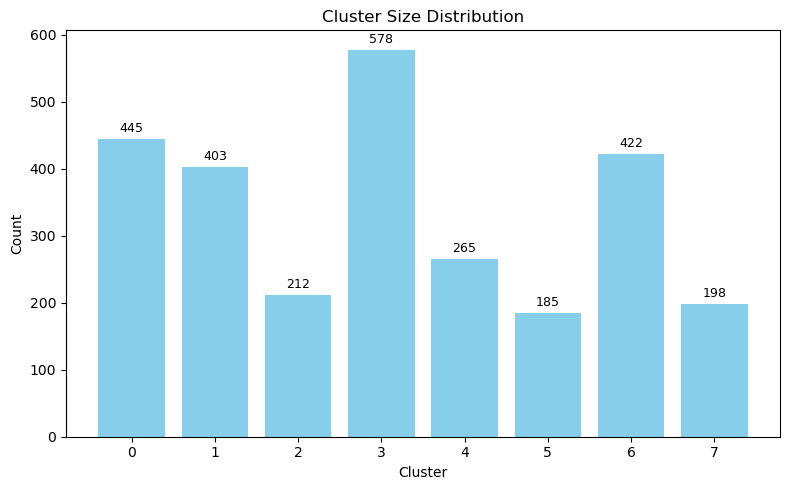

In [57]:
# Cell V2 — Cluster size distribution (with table + bar labels)

# Compute counts
unique, counts = np.unique(labels, return_counts=True)

# Create DataFrame table
cluster_table = pd.DataFrame({
    "Cluster": unique,
    "Count": counts
})
print("=== Cluster Size Table ===")
display(cluster_table)

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(unique, counts, color="skyblue")

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + max(counts)*0.01,
        str(int(height)),
        ha='center', va='bottom', fontsize=9
    )

plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/cluster_sizes.png", dpi=200)
plt.show()


=== Subject Frequency Table ===


,Subject,Count
0,Case_Based,298
1,Genetic_Algorithms,418
2,Neural_Networks,818
3,Probabilistic_Methods,426
4,Reinforcement_Learning,217
5,Rule_Learning,180
6,Theory,351


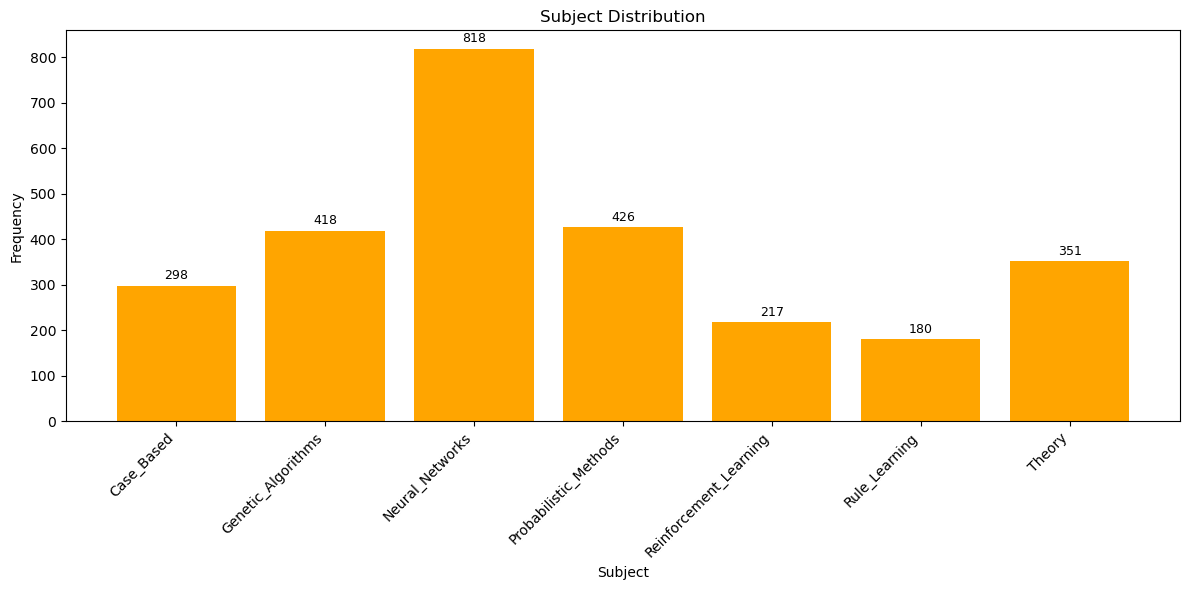

In [59]:
# Cell V3 — Subject frequency plot (with table + bar labels)

subject_counts = pd.Series(subjects).value_counts().sort_index()

# Create DataFrame table
subject_table = pd.DataFrame({
    "Subject": subject_counts.index,
    "Count": subject_counts.values
})
print("=== Subject Frequency Table ===")
display(subject_table)

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar(subject_counts.index, subject_counts.values, color='orange')

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + max(subject_counts.values)*0.01,
        str(int(height)),
        ha='center', va='bottom', fontsize=9
    )

plt.title("Subject Distribution")
plt.xlabel("Subject")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/subject_distribution.png", dpi=200)
plt.show()


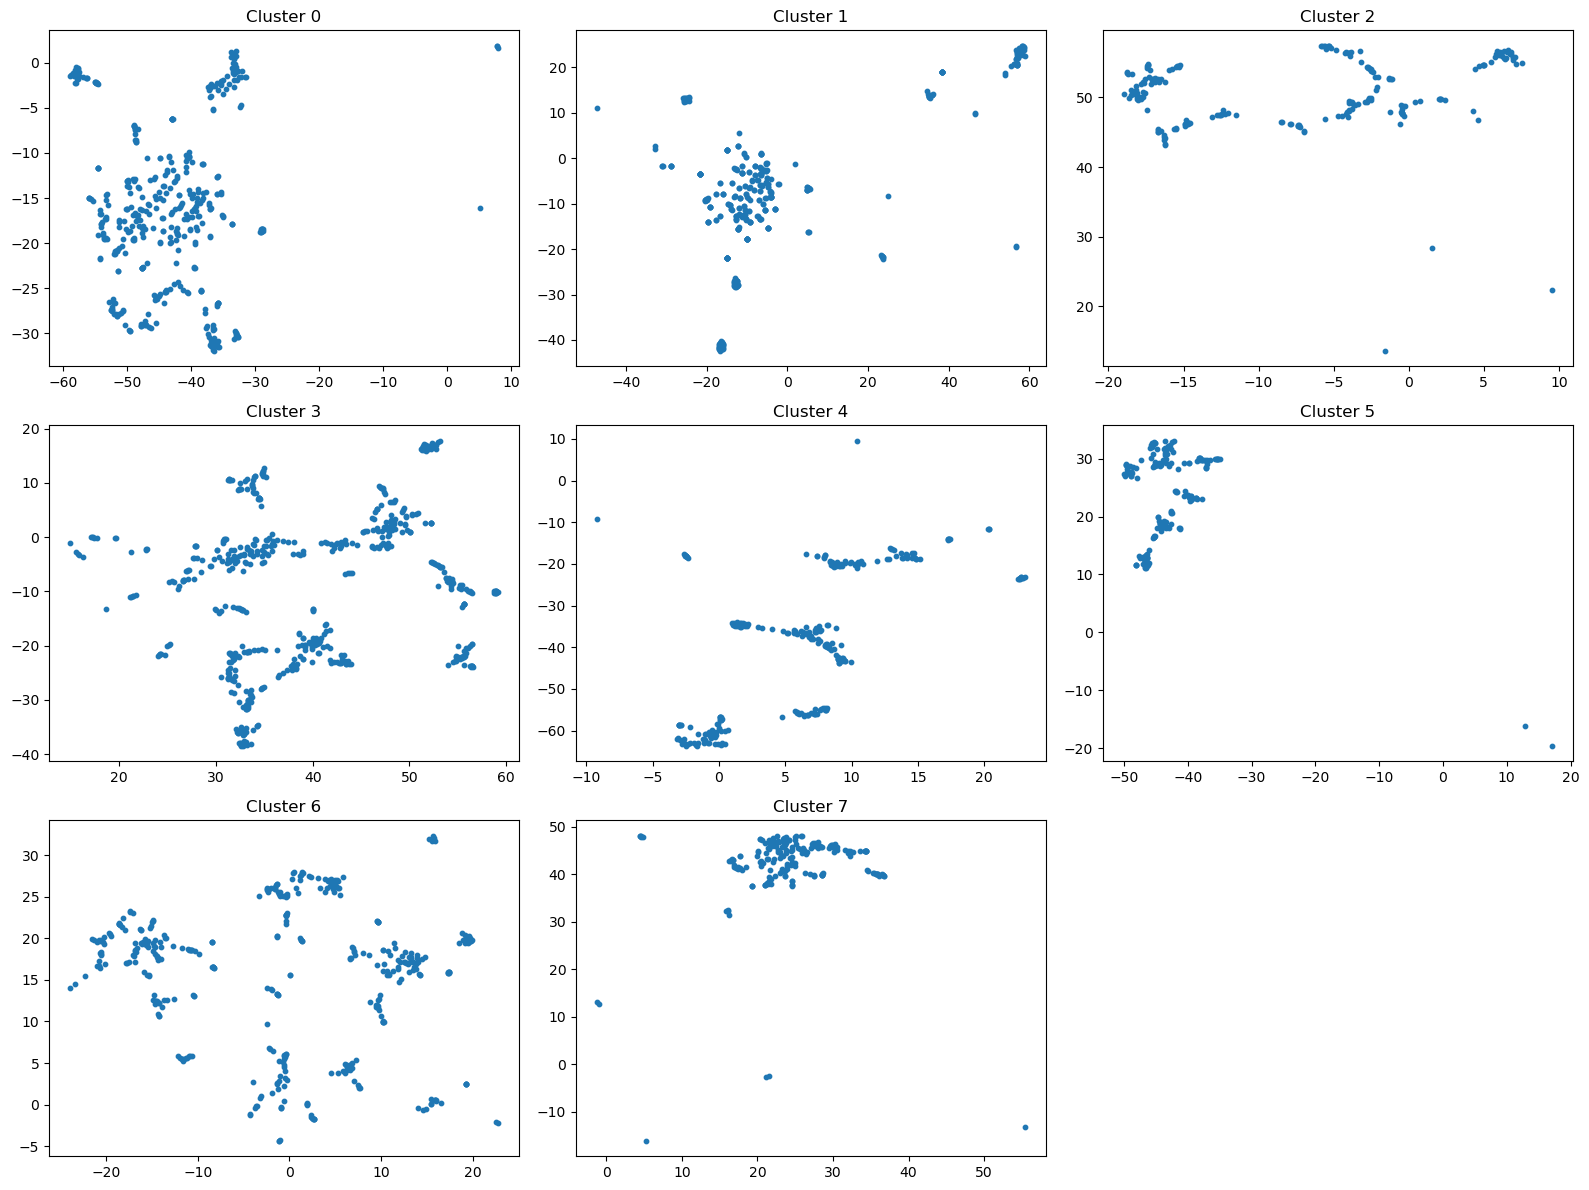

In [37]:
# Cell V7 — t-SNE per-cluster grid
clusters = np.unique(labels)
cols = 3
rows = int(np.ceil(len(clusters)/cols))

plt.figure(figsize=(16,12))
for i, c in enumerate(clusters):
    plt.subplot(rows, cols, i+1)
    mask = (labels == c)
    plt.scatter(proj[mask,0], proj[mask,1], s=10)
    plt.title(f"Cluster {c}")

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/tsne_clusters_grid.png", dpi=200)
plt.show()


In [55]:
# # Simple Cell — 2D interactive Plotly (clusters colored) + PNG via matplotlib (no kaleido)
# import os, json, random
# import plotly.graph_objects as go
# from IPython.display import IFrame
# import matplotlib.pyplot as plt
# import numpy as np

# out_dir = "outputs"
# os.makedirs(out_dir, exist_ok=True)

# # Ensure pos exists (compute if not)
# if 'pos' not in globals():
#     pos = nx.spring_layout(G.to_undirected(), seed=42, k=0.15, iterations=50)

# # Build sampled edges (avoid too many lines)
# MAX_EDGES_TO_PLOT = 4000
# edges_all = list(G.edges())
# sampled_edges = edges_all if len(edges_all) <= MAX_EDGES_TO_PLOT else random.sample(edges_all, MAX_EDGES_TO_PLOT)

# edge_x, edge_y = [], []
# for u, v in sampled_edges:
#     if u in pos and v in pos:
#         x0, y0 = pos[u]; x1, y1 = pos[v]
#         edge_x += [x0, x1, None]
#         edge_y += [y0, y1, None]

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     mode='lines',
#     line=dict(width=0.9, color='rgba(90,90,90,0.6)'),
#     hoverinfo='none'
# )

# # Node coords and colors: use labels (KMeans) aligned with node_list
# node_x, node_y, hover_texts, node_sizes = [], [], [], []
# degrees = dict(G.degree())
# deg_vals = np.array([degrees.get(n,0) for n in node_list], dtype=float)
# if deg_vals.max() > 0:
#     size_norm = 6 + (deg_vals - deg_vals.min())/(deg_vals.max()-deg_vals.min())*12
# else:
#     size_norm = np.full(len(node_list), 8.0)

# # labels is a numpy array aligned to node_list
# label_arr = np.array(labels) if 'labels' in globals() else np.zeros(len(node_list), dtype=int)

# for i, n in enumerate(node_list):
#     if n not in pos:
#         continue
#     x, y = pos[n]
#     node_x.append(x); node_y.append(y)
#     txt = f"Node: {n}"
#     nd = G.nodes.get(n, {})
#     if 'subject' in nd and pd.notna(nd['subject']):
#         txt += f"<br>subject: {nd['subject']}"
#     if 'labels' in nd and pd.notna(nd['labels']):
#         txt += f"<br>type: {nd['labels']}"
#     txt += f"<br>degree: {degrees.get(n,0)}"
#     hover_texts.append(txt)
#     node_sizes.append(float(size_norm[i]))

# # Map cluster ids to colors directly in Plotly by passing label_arr as color
# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     text=hover_texts,
#     marker=dict(
#         size=node_sizes,
#         color=label_arr.tolist(),      # color by cluster id
#         colorscale='Viridis',
#         showscale=True,
#         colorbar=dict(title='cluster'),
#         line=dict(width=0.2, color='rgba(0,0,0,0.2)')
#     )
# )

# fig = go.Figure(data=[edge_trace, node_trace],
#                 layout=go.Layout(
#                     title="Citation Graph — clusters (interactive)",
#                     showlegend=False,
#                     margin=dict(b=20,l=5,r=5,t=40),
#                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                     width=900, height=700
#                 ))

# # Save a self-contained HTML (open in browser)
# html_path = os.path.join(out_dir, "graph_clusters_colored.html")
# fig.write_html(html_path, include_plotlyjs=True, full_html=True)
# print("Saved interactive HTML to:", html_path)

# # Display inline (iframe)
# try:
#     display(IFrame(src=html_path, width=900, height=700))
# except:
#     fig.show()

# # --- Save static PNG using matplotlib (no kaleido needed) ---
# # Build arrays for matplotlib scatter (must match Plotly view)
# xs = [pos[n][0] for n in node_list if n in pos]
# ys = [pos[n][1] for n in node_list if n in pos]
# cs = label_arr.tolist()  # cluster ids
# sz = [size_norm[i] for i,n in enumerate(node_list) if n in pos]

# plt.figure(figsize=(10,8))
# scatter = plt.scatter(xs, ys, c=cs, s=np.clip(sz, 6, 60), cmap='viridis', alpha=0.9)
# plt.title("Citation Graph (clusters colored) — static")
# plt.axis('off')
# cbar = plt.colorbar(scatter)
# cbar.set_label('cluster id')
# png_path = os.path.join(out_dir, "graph_clusters_colored.png")
# plt.savefig(png_path, dpi=200, bbox_inches='tight')
# plt.show()
# print("Saved static PNG to:", png_path)

# # If HTML doesn't open by double-click, run:
# print("\nIf the HTML file doesn't open directly, run:\n  python -m http.server 8000\nand visit http://localhost:8000/outputs/graph_clusters_colored.html")


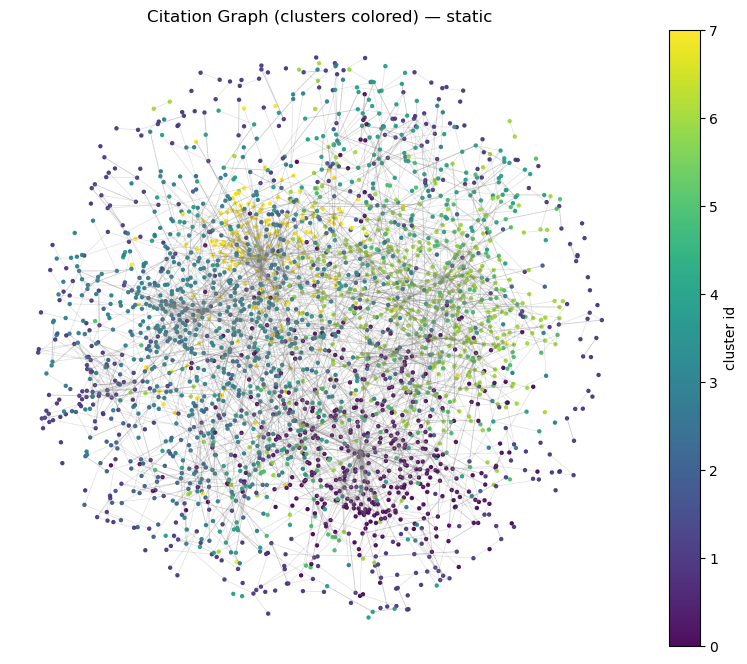

Saved static PNG with visible edges to: outputs/graph_clusters_colored.png


In [49]:
# --- Save static PNG using matplotlib (WITH VISIBLE EDGES) ---
xs = {n: pos[n][0] for n in node_list if n in pos}
ys = {n: pos[n][1] for n in node_list if n in pos}

plt.figure(figsize=(10, 8))

# 1. Draw edges first (faint grey lines)
for u, v in sampled_edges:
    if u in xs and v in xs:
        plt.plot([xs[u], xs[v]], [ys[u], ys[v]],
                 color='gray', alpha=0.25, linewidth=0.5)

# 2. Draw nodes on top (colored by cluster)
cs = label_arr.tolist()
sz = [size_norm[i] for i, n in enumerate(node_list) if n in xs]

scatter = plt.scatter(
    [xs[n] for n in node_list if n in xs],
    [ys[n] for n in node_list if n in ys],
    c=cs, s=np.clip(sz, 10, 60),
    cmap='viridis', alpha=0.95, edgecolors='none'
)

plt.title("Citation Graph (clusters colored) — static")
plt.axis('off')

cbar = plt.colorbar(scatter)
cbar.set_label('cluster id')

png_path = os.path.join(out_dir, "graph_clusters_colored.png")
plt.savefig(png_path, dpi=200, bbox_inches='tight')
plt.show()

print("Saved static PNG with visible edges to:", png_path)


Leiden/igraph not available (will try Louvain fallback). Error: No module named 'igraph'
Using python-louvain as fallback.
Running Louvain (python-louvain) fallback on undirected graph...
Louvain produced 105 communities (with -1 possibly for missing).
Silhouette (KMeans, k=8): 0.3568
Silhouette (Leiden): 0.1190


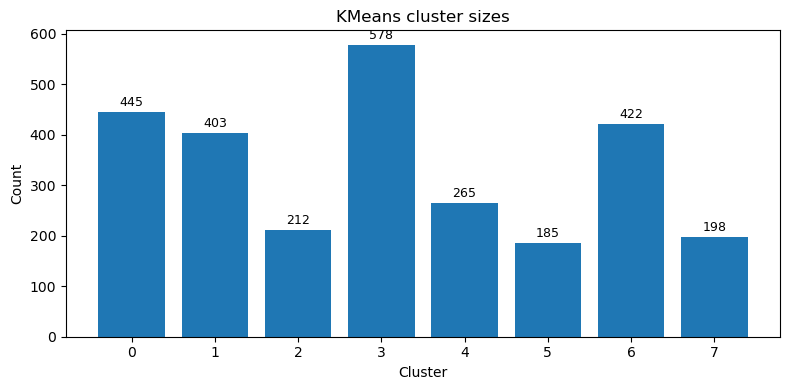

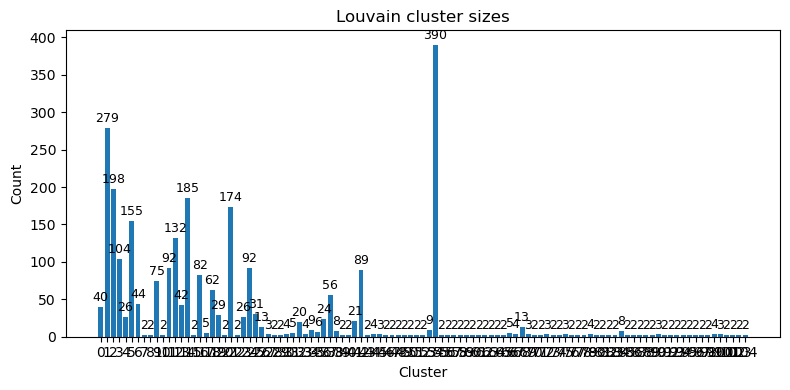

Cluster size tables saved to outputs/
Saved cluster vs subject counts to outputs/kmeans_cluster_vs_subject.csv


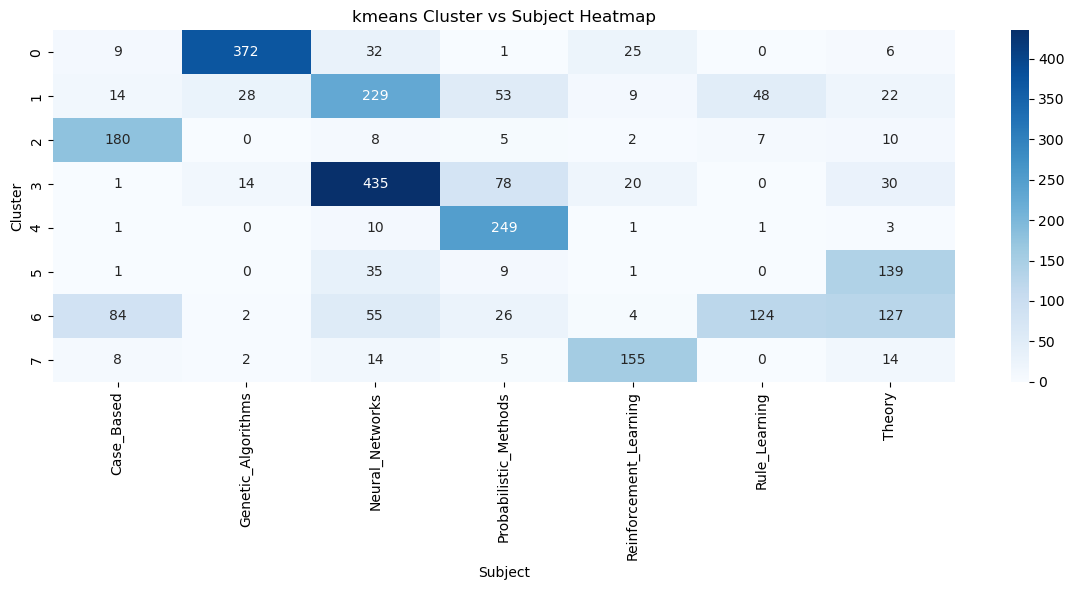

Saved cluster vs subject counts to outputs/leiden_cluster_vs_subject.csv


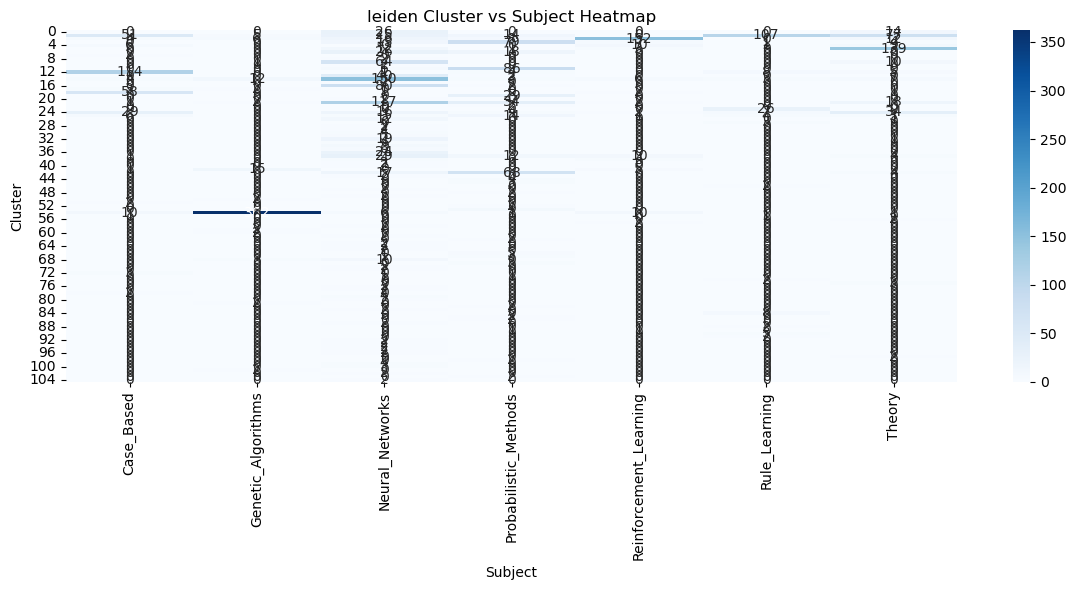

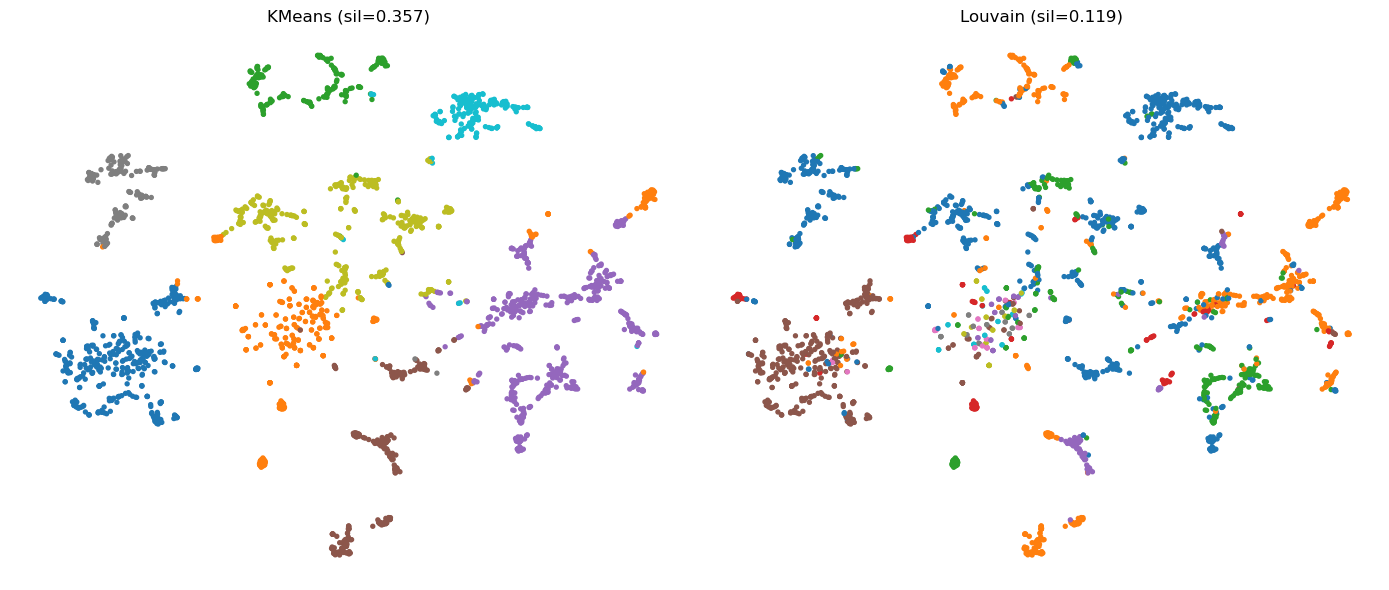

Saved clustering comparison summary to: outputs/clustering_comparison_summary.csv


,method,n_clusters,silhouette
0,KMeans,8,0.356768
1,Louvain,105,0.118996


Saved full node->cluster assignments to outputs/node_cluster_assignments.csv

Done. Outputs saved to 'outputs/' folder. Review the PNGs/CSVs for tables and annotated charts.


In [63]:
# === Cell: Leiden + Comparison + Annotated Bar Charts + Tables ===
# Requires: networkx, numpy, pandas, matplotlib, seaborn, sklearn
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from collections import Counter

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

# 1) Ensure we have kmeans labels available (from earlier)
kmeans_labels = np.array(labels)  # existing KMeans labels

# 2) Try to run Leiden (preferred). If not possible, fallback to Louvain (community)
have_leiden = False
try:
    # Try importing leidenalg + igraph
    import igraph as ig
    import leidenalg
    have_leiden = True
except Exception as e:
    print("Leiden/igraph not available (will try Louvain fallback). Error:", e)
    try:
        import community as community_louvain
        print("Using python-louvain as fallback.")
    except Exception as e2:
        print("Louvain not available either. To enable graph community detection install packages:")
        print(" pip install python-louvain     # or pip install igraph leidenalg")
        raise

# build node->index mapping
node_to_idx = {n: i for i, n in enumerate(node_list)}

# build edge list as index pairs (ignore edges with missing nodes)
edge_idx = [(node_to_idx[u], node_to_idx[v]) for u,v in G.edges() if u in node_to_idx and v in node_to_idx]

# Run community detection
if have_leiden:
    print("Running Leiden (igraph + leidenalg)...")
    ig_graph = ig.Graph(n=len(node_list), edges=edge_idx, directed=True)
    # Use modularity-like partition (RBConfigurationVertexPartition) or CPM
    partition = leidenalg.find_partition(ig_graph, leidenalg.RBConfigurationVertexPartition, resolution_parameter=1.0)
    leiden_labels = np.array(partition.membership)
    print("Leiden produced", len(set(leiden_labels)), "communities.")
else:
    print("Running Louvain (python-louvain) fallback on undirected graph...")
    # create undirected copy for Louvain
    G_und = G.to_undirected()
    # python-louvain returns dict node->community
    part = community_louvain.best_partition(G_und, random_state=42)
    # map to array aligned to node_list
    leiden_labels = np.array([part.get(n, -1) for n in node_list])
    print("Louvain produced", len(set(leiden_labels)) - (1 if -1 in set(leiden_labels) else 0), "communities (with -1 possibly for missing).")

# 3) Compute silhouette scores (if valid)
def safe_silhouette(X, labels):
    # silhouette requires 2 <= n_clusters <= n_samples-1
    unique = np.unique(labels)
    if len(unique) < 2 or len(unique) >= X.shape[0]:
        return np.nan
    try:
        return silhouette_score(X, labels)
    except Exception:
        return np.nan

sil_kmeans = safe_silhouette(umap_emb, kmeans_labels)
sil_leiden = safe_silhouette(umap_emb, leiden_labels)

print(f"Silhouette (KMeans, k={len(np.unique(kmeans_labels))}): {sil_kmeans:.4f}")
print(f"Silhouette (Leiden): {sil_leiden:.4f}")

# 4) Cluster-size bar charts with annotations and CSV tables
def plot_bar_counts(arr, title, fname):
    cnt = Counter(arr)
    items = sorted(cnt.items(), key=lambda x: x[0])
    keys = [k for k,_ in items]
    vals = [v for _,v in items]
    plt.figure(figsize=(8,4))
    bars = plt.bar([str(k) for k in keys], vals, color='tab:blue')
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    # annotate counts on bars
    for rect, v in zip(bars, vals):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + max(vals)*0.01, str(v), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, fname), dpi=200)
    plt.show()
    # also return table
    df = pd.DataFrame({'cluster': keys, 'count': vals})
    return df

k_df = plot_bar_counts(kmeans_labels, "KMeans cluster sizes", "kmeans_cluster_sizes.png")
l_df = plot_bar_counts(leiden_labels, "Louvain cluster sizes", "louvain_cluster_sizes.png")

k_df.to_csv(os.path.join(out_dir, "kmeans_cluster_sizes.csv"), index=False)
l_df.to_csv(os.path.join(out_dir, "louvain_cluster_sizes.csv"), index=False)
print("Cluster size tables saved to outputs/")

# 5) Cluster vs Subject crosstabs and heatmaps (annotated + CSV)
# build subject list aligned to node_list
df_indexed = nodes_df.set_index(node_id_col)
subjects_aligned = [df_indexed.loc[n, "subject"] if n in df_indexed.index else "Unknown" for n in node_list]

def cluster_subject_heatmap(cluster_arr, name_prefix):
    ct = pd.crosstab(cluster_arr, subjects_aligned)
    # save
    csv_path = os.path.join(out_dir, f"{name_prefix}_cluster_vs_subject.csv")
    ct.to_csv(csv_path)
    print(f"Saved cluster vs subject counts to {csv_path}")
    # plot heatmap with annotations
    plt.figure(figsize=(12,6))
    sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name_prefix} Cluster vs Subject Heatmap")
    plt.xlabel("Subject")
    plt.ylabel("Cluster")
    plt.tight_layout()
    png_path = os.path.join(out_dir, f"{name_prefix}_cluster_subject_heatmap.png")
    plt.savefig(png_path, dpi=200)
    plt.show()
    return ct

ct_k = cluster_subject_heatmap(kmeans_labels, "kmeans")
ct_l = cluster_subject_heatmap(leiden_labels, "leiden")

# 6) t-SNE plots colored by clusters (side-by-side)
def tsne_scatter_compare(proj2d, arr1, arr2, label1="KMeans", label2="Leiden", fname="tsne_compare.png"):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.scatter(proj2d[:,0], proj2d[:,1], c=arr1, cmap='tab10', s=8)
    plt.title(f"{label1} (sil={safe_silhouette(umap_emb, arr1):.3f})")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.scatter(proj2d[:,0], proj2d[:,1], c=arr2, cmap='tab10', s=8)
    plt.title(f"{label2} (sil={safe_silhouette(umap_emb, arr2):.3f})")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, fname), dpi=200)
    plt.show()

tsne_scatter_compare(proj, kmeans_labels, leiden_labels, label1="KMeans", label2="Louvain", fname="tsne_kmeans_vs_louvain.png")

# 7) Numeric comparison table and save
summary = pd.DataFrame({
    "method": ["KMeans", "Louvain"],
    "n_clusters": [len(np.unique(kmeans_labels)), len(np.unique(leiden_labels))],
    "silhouette": [sil_kmeans, sil_leiden]
})
summary.to_csv(os.path.join(out_dir, "clustering_comparison_summary.csv"), index=False)
print("Saved clustering comparison summary to:", os.path.join(out_dir, "clustering_comparison_summary.csv"))
display(summary)

# 8) Save full cluster assignments per node for both methods (CSV)
assign_df = pd.DataFrame({
    node_id_col: node_list,
    "kmeans_cluster": kmeans_labels,
    "louvain_cluster": leiden_labels,
    "subject": subjects_aligned
})
assign_df.to_csv(os.path.join(out_dir, "node_cluster_assignments.csv"), index=False)
print("Saved full node->cluster assignments to outputs/node_cluster_assignments.csv")

print("\nDone. Outputs saved to 'outputs/' folder. Review the PNGs/CSVs for tables and annotated charts.")
